# Training a transformer

Some proposals

- Train the transformer with multiple heads (various models with hyperparameter $L, H$) in solving for SHO.
- Use linear regression 

## Setup and imports

In [1]:
import functools
import sys
from pathlib import Path
from typing import Callable

import circuitsvis as cv
import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import eindex
from IPython.display import display
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.hook_points import HookPoint

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

### Generating data

The time series data of a particle's movement in a 2D phase space is computed directly with random initializations of values $\omega_0, x_0, v_0, \Delta t$.

In [2]:
## Data generation
import math

def generate_harmonic_data_torch(
    n_sequences=5000,
    n_steps=65,
    w0_range=(math.pi/4, 5*math.pi/4),
    out_of_distribution=False,
    device='cpu',
    seed=None
):
    """
    Generate undamped harmonic oscillator sequences using PyTorch.
    
    Each sequence is length n_steps, and each time step has shape (2,):
        [ x(t), v(t) ].

    Args:
        n_sequences (int): Number of sequences to generate.
        n_steps (int): Number of time steps per sequence.
        w0_range (tuple or list): For in-distribution data, we uniformly sample
            ω₀ in [w0_range[0], w0_range[1]]. For OOD data, we sample from
            [0, π/4] U [5π/4, 3π/2].
        out_of_distribution (bool): If True, sample ω₀ from the OOD range.
        device (str): 'cpu' or 'cuda', for where to place the generated tensors.
        seed (int or None): Set a random seed for reproducibility, or None.

    Returns:
        data (t.FloatTensor): Shape (n_sequences, n_steps, 2),
            storing [x(t), v(t)] at each time step.
    """
    if seed is not None:
        t.manual_seed(seed)

    # Allocate the output data
    data = t.zeros((n_sequences, n_steps, 2), dtype=t.float32, device=device)

    # Sample initial positions/velocities in [-1, 1]
    x0_all = t.empty(n_sequences, device=device).uniform_(-1, 1)
    v0_all = t.empty(n_sequences, device=device).uniform_(-1, 1)

    # Sample ω₀
    if out_of_distribution:
        # We want half in [0, π/4], half in [5π/4, 3π/2]
        half = n_sequences // 2
        w0_1 = t.empty(half, device=device).uniform_(0.0, math.pi/4)
        w0_2 = t.empty(n_sequences - half, device=device).uniform_(5*math.pi/4, 3*math.pi/2)
        w0_all = t.cat([w0_1, w0_2], dim=0)
        # Shuffle so there's no ordering by range
        idx_perm = t.randperm(n_sequences, device=device)
        w0_all = w0_all[idx_perm]
    else:
        # In-distribution: ω₀ ∈ [π/4, 5π/4]
        w0_min, w0_max = w0_range
        w0_all = t.empty(n_sequences, device=device).uniform_(w0_min, w0_max)

    # For each sequence, sample Δt ∈ [0, 2π/ω₀]. 
    # This range depends on w0 individually, so we do a small loop:
    dt_all = []
    for i in range(n_sequences):
        w0 = w0_all[i]
        if w0 == 0:
            dt_all.append(0.0)
        else:
            dt_all.append(t.empty(1, device=device).uniform_(0.0, (2*math.pi)/(w0)).item())

    dt_all = t.tensor(dt_all, dtype=t.float32, device=device)

    # Generate time series
    for i in range(n_sequences):
        w0  = w0_all[i]
        x0  = x0_all[i]
        v0  = v0_all[i]
        dt  = dt_all[i]

        # Time steps: t = 0, dt, 2dt, ..., (n_steps-1)*dt
        t_vals = dt * t.arange(n_steps, device=device, dtype=t.float32)

        if w0 != 0.0:
            # x(t)
            x_vals = x0 * t.cos(w0 * t_vals) + (v0 / w0) * t.sin(w0 * t_vals)
            # v(t)
            v_vals = -x0 * w0 * t.sin(w0 * t_vals) + v0 * t.cos(w0 * t_vals)
        else:
            # If w0 = 0, the equation is degenerate. Let's just hold x constant
            # or do something minimal. Here we do x(t)=x0, v(t)=v0 for all t.
            x_vals = x0 * t.ones_like(t_vals)
            v_vals = v0 * t.ones_like(t_vals)

        data[i, :, 0] = x_vals
        data[i, :, 1] = v_vals

    return data


train_data = generate_harmonic_data_torch(
    n_sequences=5000,
    n_steps=65,
    w0_range=(math.pi/4, 5*math.pi/4),
    out_of_distribution=False,
    device=device,
    seed=42
)
print("Train data shape:", train_data.shape)  # (5000, 65, 2)

test_data_ood = generate_harmonic_data_torch(
    n_sequences=5000,
    n_steps=65,
    out_of_distribution=True,
    device=device,
    seed=999
)
print("OOD test data shape:", test_data_ood.shape)  #

Train data shape: torch.Size([5000, 65, 2])
OOD test data shape: torch.Size([5000, 65, 2])


### Testing for generated data

We plot the phase space for various cases. Note that since we have set $\Delta t \sim U[0, 2\pi / \omega_0]$, it is possible for the particle to move anywhere within one ''time step'' - just a note that the time step in the current context should not be perceived as something small in magnitude.

In [3]:
import random
import matplotlib.pyplot as plt


def plot_phase_diagrams(dataset, n_examples=5):
    """
    Plots x vs. v (the "phase diagram") for a few randomly selected sequences.

    Args:
        dataset (torch.Tensor): Shape (n_sequences, n_steps, 2), 
                                each entry is [x(t), v(t)] at each time step.
        n_examples (int): Number of random sequences to plot.
    """

    # If your data is on the GPU, move it to CPU for plotting
    data_cpu = dataset.cpu()

    # Randomly choose some sequence indices (without replacement)
    indices = random.sample(range(data_cpu.shape[0]), n_examples)

    # Create subplots: one phase diagram per chosen sequence
    fig, axes = plt.subplots(1, n_examples, figsize=(5 * n_examples, 4), 
                             sharey=True)

    # If there's only one example, make `axes` iterable by wrapping in a list
    if n_examples == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        # Extract x(t) and v(t) for this sequence
        x_t = data_cpu[idx, :, 0].numpy()
        v_t = data_cpu[idx, :, 1].numpy()

        # Plot x vs. v
        ax = axes[i]
        ax.plot(x_t, v_t, marker="o", markersize=3, linewidth=1)
        ax.set_xlabel("x(t)")
        ax.set_ylabel("v(t)")
        ax.set_title(f"Sequence {idx}")

    plt.tight_layout()
    plt.show()

In [4]:
train_data = generate_harmonic_data_torch(
    n_sequences=5000,
    n_steps=65,
    w0_range=(math.pi/4, 5*math.pi/4),
    out_of_distribution=False,
    seed=42
)

# 2) Plot phase diagrams for 3 random sequences
plot_phase_diagrams(dataset['sequences_test'], n_examples=3)

NameError: name 'dataset' is not defined

## Building the transformer

Let's summarize the parameters used in the `train_model.py` file.



In [150]:


# print(hooked_transformer)

Moving model to device:  cuda


## In-context training of the transformer

It seems by default `TransformerLens` does not deal with continuous-space inputs (as we are trying to do here modelling the phase space). Here are some workarounds on top of the default model where we

1. Changed the embedding to `PhaseSpaceEmbed`, that takes phase space dimension and embed it into `d_model`, which for simplicity we have taken to be the same as the phase space dimension.
   
2. Ablated the position embedding entirely.

In [3]:
class PhaseSpaceEmbed(nn.Module):
    def __init__(self, d_model: int, d_phase_space: int):
        super().__init__()
        self.d_model = d_model
        self.d_phase_space = d_phase_space
        self.W_E = nn.Parameter(t.randn(d_model, d_phase_space))
        self.b_E = nn.Parameter(t.randn(d_model))

    def forward(self, x: Tensor) -> Tensor:
        return F.linear(x, self.W_E, self.b_E)
    
class IdentityEmbed(nn.Module):
    def __init__(self, d_model: int, d_phase_space: int):
        super().__init__()
        self.d_model = d_model
        self.d_phase_space = d_phase_space

    def forward(self, x: Tensor) -> Tensor:
        return x

class AblatedPosEmbed(nn.Module):
    def __init__(self, d_model, *kwargs):
        super().__init__()
        self.d_model = d_model
        
    def forward(self, x: Tensor, *kwargs) -> Tensor:
        return t.zeros(x.shape[0], x.shape[1], self.d_model, device=x.device)

class TimeEmbed(nn.Module):
    def __init__(self, seq_len: int, d_model: int, *kwargs):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.W_pos = nn.Parameter(t.zeros(seq_len, d_model))
        # initialize to zero embedding
    
    def forward(self, x: Tensor, *kwargs) -> Tensor:
        seq_len = x.shape[1]
        positions = t.arange(0, seq_len, dtype=t.long, device=x.device)
        embedded_pos = self.W_pos[positions]
        
        return embedded_pos

In [ ]:
import sklearn


: 

In [4]:
## Setting up the configuration
from transformer_lens import HookedTransformer, HookedTransformerConfig

def model_train_init():
    cfg = HookedTransformerConfig(
        n_layers=2,
        d_model=16,
        n_ctx=66,
        d_head=10,
        n_heads=4,
        d_mlp=16*4,
        act_fn="gelu",
        d_vocab=2,
        normalization_type=None,
    )

    model = HookedTransformer(cfg)

    train_cfg = {
        "lr": 1e-3,
        "batch_size": 64,
        "n_epochs": 200,
        "checkpoint_every": 10,
        "betas": (0.9, 0.98),
    }
    
    model.embed = PhaseSpaceEmbed(cfg.d_model, cfg.d_vocab)
    model.pos_embed = TimeEmbed(cfg.n_ctx, cfg.d_model)
    
    return cfg, model, train_cfg

# modify the embedding


model.to(device)
train_data.to(device)
model(train_data)



Moving model to device:  cuda


tensor([[[ 3.6973,  1.2191],
         [ 1.6697,  1.8671],
         [-0.4876, -1.1099],
         ...,
         [ 1.6946, -0.1904],
         [ 4.1521,  1.6969],
         [ 1.8856,  1.6614]],

        [[-0.3068, -2.3982],
         [ 5.4749, -1.3114],
         [ 3.6539, -1.9828],
         ...,
         [ 5.0064,  0.8195],
         [ 4.8161,  0.4418],
         [ 1.2460, -3.5357]],

        [[ 0.5349,  1.1090],
         [ 1.5769,  1.8203],
         [ 0.2581,  0.2211],
         ...,
         [ 0.8856,  0.9320],
         [ 0.2507,  0.4192],
         [ 1.7690,  1.4441]],

        ...,

        [[-0.1827, -1.8174],
         [-0.0536, -1.6726],
         [ 0.0781, -1.5144],
         ...,
         [ 3.5349, -0.1687],
         [ 3.4526, -0.2020],
         [ 3.3861, -0.2704]],

        [[ 1.8480,  1.9210],
         [ 3.4324,  1.3487],
         [ 3.7821,  0.9040],
         ...,
         [ 5.4592,  0.8865],
         [ 7.3046,  0.8761],
         [ 7.6868,  0.8269]],

        [[-0.1224, -1.6107],
       

In [7]:
from torchinfo import summary

summary(model.train(), input_size=(5000, 65, 2), device=device)

Moving model to device:  cuda


Layer (type:depth-idx)                   Output Shape              Param #
HookedTransformer                        [5000, 65, 2]             --
├─PhaseSpaceEmbed: 1-1                   [5000, 65, 16]            48
├─HookPoint: 1-2                         [5000, 65, 16]            --
├─TimeEmbed: 1-3                         [65, 16]                  1,040
├─HookPoint: 1-4                         [65, 16]                  --
├─ModuleList: 1-5                        --                        --
│    └─TransformerBlock: 2-1             [5000, 65, 16]            --
│    │    └─HookPoint: 3-1               [5000, 65, 16]            --
│    │    └─Identity: 3-2                [5000, 65, 16]            --
│    │    └─Identity: 3-3                [5000, 65, 16]            --
│    │    └─Identity: 3-4                [5000, 65, 16]            --
│    │    └─Attention: 3-5               [5000, 65, 16]            2,696
│    │    └─HookPoint: 3-6               [5000, 65, 16]            --
│    │   

In [6]:
dataset = t.load("C:\\Users\\15896\\myenv\\Hydra\\mech_interp_capstone\\scratches\\spring_data\\undamped.pth")

In [5]:

from torch.utils.data import TensorDataset, DataLoader
## training data
## pre-defined as following:

# train_data.shape = (n_sample, n_timesteps, d_phase_space) = (5000, 65, 2), random_seed=42
# test_data_ood.shape = (n_sample, n_timesteps, d_phase_space) = (5000, 65, 2), random_seed=999


train_data.to(device)
test_data_ood.to(device)

datadict = t.load("C:\\Users\\15896\\myenv\\Hydra\\mech_interp_capstone\\scratches\\spring_data\\undamped.pth")
train_data = datadict["sequences_train"].to(device)
trainomegas = datadict["train_omegas"]
test_data_ood = datadict["sequences_test"].to(device)
testomegas = datadict["test_omegas"]

# train_data = generate_harmonic_data_torch(
#     n_sequences=1000,
#     n_steps=65,
#     w0_range=(math.pi/4, 5*math.pi/4),
#     out_of_distribution=False,
#     seed=42
# ).to(device)
# 
# test_data_ood = generate_harmonic_data_torch(
#     n_sequences=1000,
#     n_steps=65,
#     out_of_distribution=True,
#     seed=999
# ).to(device)
# 

train_dataset = TensorDataset(train_data)  # simple dataset with just features
train_loader = DataLoader(
    train_dataset, 
    batch_size=train_cfg["batch_size"],  # e.g., 64
    shuffle=True
)

test_dataset = TensorDataset(test_data_ood)  # simple dataset with just features
test_loader = DataLoader(
    test_dataset, 
    batch_size=train_cfg["batch_size"],  # e.g., 64
    shuffle=False
)


In [14]:
from generate_data import generate_springdata

train_data, train_omegas, test_data_ood, test_omegas = generate_springdata(
    num_samples=1000,
    sequence_length=64,
    plot=False,
)

train_data = train_data.to(device)
test_data_ood = test_data_ood.to(device)


#### The model

In [59]:
## Initialize the model
def model_train_init():
    cfg = HookedTransformerConfig(
        n_layers=3,
        d_model=8,
        n_ctx=66,
        d_head=4,
        n_heads=2,
        d_mlp=8*4,
        act_fn="gelu",
        d_vocab=2,
        normalization_type=None,
    )

    model = HookedTransformer(cfg)

    train_cfg = {
        "lr": 1e-3,
        "batch_size": 64,
        "n_epochs": 200,
        "checkpoint_every": 10,
        "betas": (0.9, 0.98),
    }
    
    model.embed = PhaseSpaceEmbed(cfg.d_model, cfg.d_vocab)
    model.pos_embed = TimeEmbed(cfg.n_ctx, cfg.d_model)
    model = model.to(device)
    return cfg, model, train_cfg


t.manual_seed(0)
cfg, model, train_cfg = model_train_init()

Moving model to device:  cuda


#### Generate dataset

In [60]:
from generate_data import generate_springdata

author = 'SK'
num_sample = 400
seq_len = 64

if author == 'SK':
    train_data, train_omegas, test_data_ood, test_omegas = generate_springdata(
        num_samples=num_sample,
        sequence_length=seq_len,
        plot=False,
    )

    train_data = train_data.to(device)
    test_data_ood = test_data_ood.to(device)

if author == 'CL':
    train_data = generate_harmonic_data_torch(
        n_sequences=num_sample,
        n_steps=seq_len + 1,
        w0_range=(math.pi/4, 5*math.pi/4),
        out_of_distribution=False,
        seed=42
    ).to(device)
    
    test_data_ood = generate_harmonic_data_torch(
        n_sequences=num_sample // 2,
        n_steps= seq_len + 1,
        out_of_distribution=True,
        seed=999
    ).to(device)
    


#### Training

In [61]:

train_losses = []
test_losses = []
optimizer = t.optim.Adam(model.parameters(), lr=train_cfg["lr"], betas=train_cfg["betas"])

### Begin the training loop
train_losses = []
test_losses = []


for epoch in tqdm(range(train_cfg["n_epochs"])):
    # minibatch training
    model.train()
    for minibatch, in train_loader:
        minibatch_prediction = model(minibatch)
        train_loss = F.mse_loss(minibatch_prediction[:, :-1, :], minibatch[:, 1:, :])
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    
    # Evaluation phase
    if epoch % train_cfg["checkpoint_every"] == 0:
        model.eval()
        with t.inference_mode():
            # Evaluate on all training data
            full_train_pred = model(train_data)
            train_loss = F.mse_loss(full_train_pred[:, :-1, :], train_data[:, 1:, :])

            # Evaluate on test data
            test_pred = model(test_data_ood)
            test_loss = F.mse_loss(test_pred[:, :-1, :], test_data_ood[:, 1:, :])

            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())

            print(f"Epoch {epoch}: Train loss {train_loss.item()}, Test loss {test_loss.item()}")
    


  0%|          | 1/200 [00:00<01:55,  1.72it/s]

Epoch 0: Train loss 0.7339822053909302, Test loss 0.8998356461524963


  6%|▌         | 11/200 [00:04<01:17,  2.44it/s]

Epoch 10: Train loss 0.5596968531608582, Test loss 0.7112023830413818


 10%|█         | 21/200 [00:08<01:12,  2.48it/s]

Epoch 20: Train loss 0.26460400223731995, Test loss 0.3726861774921417


 16%|█▌        | 31/200 [00:11<00:53,  3.16it/s]

Epoch 30: Train loss 0.1639157384634018, Test loss 0.26698437333106995


 20%|██        | 41/200 [00:14<00:48,  3.27it/s]

Epoch 40: Train loss 0.11642713099718094, Test loss 0.2074391096830368


 26%|██▌       | 51/200 [00:17<00:42,  3.48it/s]

Epoch 50: Train loss 0.08610442280769348, Test loss 0.16316823661327362


 30%|███       | 61/200 [00:20<00:40,  3.40it/s]

Epoch 60: Train loss 0.06992562115192413, Test loss 0.13684943318367004


 36%|███▌      | 71/200 [00:23<00:36,  3.50it/s]

Epoch 70: Train loss 0.05913708731532097, Test loss 0.12648659944534302


 40%|████      | 81/200 [00:26<00:34,  3.40it/s]

Epoch 80: Train loss 0.05105564370751381, Test loss 0.11524105817079544


 46%|████▌     | 91/200 [00:28<00:30,  3.54it/s]

Epoch 90: Train loss 0.04490392655134201, Test loss 0.1069943904876709


 50%|█████     | 101/200 [00:31<00:28,  3.52it/s]

Epoch 100: Train loss 0.04223702847957611, Test loss 0.09898313134908676


 56%|█████▌    | 111/200 [00:34<00:25,  3.51it/s]

Epoch 110: Train loss 0.03969822824001312, Test loss 0.09238475561141968


 60%|██████    | 121/200 [00:37<00:22,  3.48it/s]

Epoch 120: Train loss 0.038186121731996536, Test loss 0.09052686393260956


 66%|██████▌   | 131/200 [00:40<00:23,  2.92it/s]

Epoch 130: Train loss 0.03376879170536995, Test loss 0.08412837982177734


 70%|███████   | 141/200 [00:44<00:19,  3.09it/s]

Epoch 140: Train loss 0.03295270726084709, Test loss 0.0804479569196701


 76%|███████▌  | 151/200 [00:47<00:14,  3.36it/s]

Epoch 150: Train loss 0.031255535781383514, Test loss 0.07919945567846298


 80%|████████  | 161/200 [00:50<00:11,  3.34it/s]

Epoch 160: Train loss 0.03241003304719925, Test loss 0.07808434218168259


 86%|████████▌ | 171/200 [00:53<00:08,  3.44it/s]

Epoch 170: Train loss 0.029949111863970757, Test loss 0.07121799141168594


 90%|█████████ | 181/200 [00:55<00:05,  3.47it/s]

Epoch 180: Train loss 0.02828129194676876, Test loss 0.06900332123041153


 96%|█████████▌| 191/200 [00:58<00:02,  3.36it/s]

Epoch 190: Train loss 0.02798428386449814, Test loss 0.06959483027458191


100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


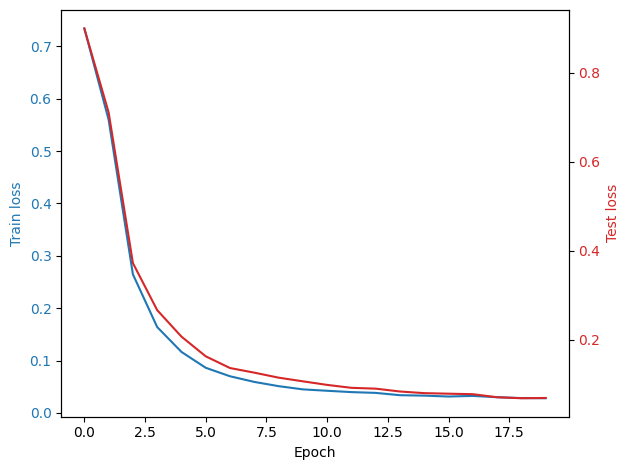

In [62]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train loss', color=color)
ax1.plot(train_losses, label="Train loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)
# plt.yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Test loss', color=color)  # we already handled the x-label with ax1
ax2.plot(test_losses, label="Test loss", color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.yscale("log")

plt.show()

In [ ]:
# Loading the model from .pth file

